In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from scipy import odr

In [59]:
df = pd.read_excel(
    r"C:\Users\dario\OneDrive\Desktop\università\Laurea_Magistrale\Laboratorio_4\Esperienze_lab\Esperienza1\Misura_Kb_tensione_copia.xlsx",
    usecols="E:J",
    nrows = 20
)
c = np.array(df["Capacità misurata (nF)"])
err_c = np.array(df["Err C (nF)"])

v = np.array(df["V2 (V)"])
err_v = np.array(df["Err V ( V)"])

c_rev = 1 / c
err_c_rev = err_c/ c**2


In [60]:
# valori numerici da inserire per il calcolo di K_B

Rv = 10*10**6
T = 300
R_av = 1.5*10**6
Y2 = (1.01*10**6)**2
U_star = ((Rv + R_av)/ Rv) / Y2
print(f"U_star = {U_star}")

U_star = 1.127340456817959e-12


si possono trascurare gli errori sulle x -> fit col metodo dei minimi quadrati


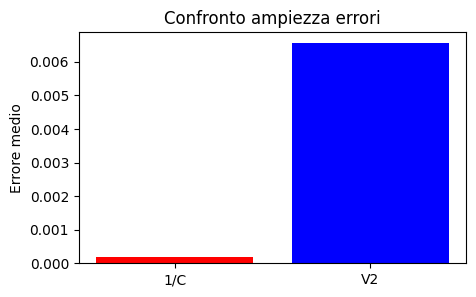

In [61]:
# print("errori di 1/C: ", list(err_c_rev), "\n")
# print("errori su V2: ", list(err_v), "\n \n ")
print("si possono trascurare gli errori sulle x -> fit col metodo dei minimi quadrati")

plt.figure(figsize = (5,3))

plt.bar(["1/C","V2"], [np.mean(err_c_rev), np.mean(err_v)], color = ["red", "blue"])
plt.ylabel("Errore medio")
plt.title("Confronto ampiezza errori")
plt.show()



## Nota per Eli per ODR

Allora, ho fatto questa divisione sgravata per un semplice motivo. Nel momento in cui ho cercato di eliminare l'intercetta con l'algoritmo ricorsivo, succedevano cose strane.
Sono sicuro sia legato al modulo Minuit che ho usato per effettuare il fit (ti mando anche le slide di lista così avrai un'idea di cosa sia e cosa faccia).

Sincero, sono le 23:35 e non ho idea del perché succedevano quelle cose strane.

Vorrò sicuramente approfondire, magari pure con un ricevimento con Della Pietra,

Ma non oggi.

ODR sta per "Orthogonal Distance Regression".

Sostanzialmente considera pure gli errori sulle x oltre che sulle y, perciò si chiama "orthogonal".

In linea di principio, se gli errori sulle x sono trascurabili, i due metodi dovrebbero essere equivalenti.

Secondo me è un problema di codice, non di statistica. Ma ok, per ora ce lo facciamo andare bene



## Errori utilizzati per V e C

Per quanto riguarda le tensioni, ci siamo basati su questo (preso dal manuale dello strumento)


<p align="center">
  <img src="attachment:image.png" width="250">
</p>


mentre per le capacità l'errore è dato da

<p align="center">
  <img src="attachment:image-2.png" width="450">
</p> 


ossia $\Delta C = (0.25 \% \cdot C \pm 1 digit)$


In particolare, l'errore sulle capacità va propagato in questo modo:

$\Delta_{1/C} = |\frac{\Delta_{C}}{C^2} | $

Ho voluto fare lo splendido.. considerandoli indipendenti (effettivamente lo sono) l'errore che ho usato nel file excel è  la **somma in quadratura** di questi due errori. Questo sia per la capacità che per la tensione


In [62]:
df

,Capacità (pF),Capacità misurata (nF),1/C,V2 (V),Err C (nF),Err V ( V)
0,10000,9.770,0.102354,1.196,0.024445,0.006063
1,13300,12.720,0.078616,1.184,0.031816,0.006004
2,4700,4.486,0.222916,1.600,0.011259,0.008062
3,22000,22.800,0.043860,1.000,0.057009,0.005099
4,33000,35.710,0.028003,1.306,0.089281,0.006606
5,7800,6.743,0.148302,1.476,0.016887,0.007447
6,6600,6.029,0.165865,1.475,0.015106,0.007442
7,78000,74.880,0.013355,1.007,0.187203,0.005133
8,68000,62.400,0.016026,1.023,0.156003,0.005212
9,5600,4.612,0.216826,1.731,0.011573,0.008713


Il modello è $y = a x + b$ 

 $V_2 = \frac{K_B T}{U^* C}$

 con $y = V_2$,  $a = \frac{K_B T}{U^* C}$ ,  x = 1/C

 Valori numerici: 

- $T = 25 °C = 300 K$
- $U^* = \frac{U_m}{Y^2} \frac{R_1}{R_1 + R_2} \frac{R_V + R_{av}}{R_V}$
 con $U_m = 10 V,  Y = 1.01·10^6 , R_2 = 9R_1, R_{av} = 1.5 M \Omega, R_V = 9.1 M \Omega$
 



 ### FIT LINEARE NEL CASO IN CUI NON SIANO TRASCURABILI GLI ERRORI SULLE X (fit con ODR)




Definisco una funzione "fit lineare", in modo da porterla richiamare nell'algoritmo di convergenza di q (intercetta)

In [63]:
def linear_func(B, x):
        return B[0] * x + B[1]

def fit_lineare(x,y, errx, erry):
    
    linear_model = odr.Model(linear_func) 

    data = odr.RealData(x, y, sx=errx, sy= erry)

    fit = odr.ODR(data, linear_model, beta0=[1, 0])  # parametri iniziali [pendenza, intercetta]

    output = fit.run()
    par, dev_std, cov = output.beta, output.sd_beta, output.cov_beta*output.res_var
    
    # in ODR la matrice di covarianza è calcolata, non perché
    # a meno di un fattore di scala, chiamato "varianza residua"
    # essa rappresnnenta 
    


     
    
    return par, dev_std , cov

In [64]:
par, dev_std , cov= fit_lineare(c_rev, v, err_c_rev, err_v)
print(f"coefficiente angolare m = {par[0]:.2f} +- {dev_std[0]:.2f} ")
print(f"intercetta q = {par[1]:.2f} +- {dev_std[1]:.2f} ")
print(dev_std)
print(f"Prima stima di kB: \nkB  = {par[0]/T*U_star*10**-9} +- {dev_std[0]/T*U_star*10**-9}")

coefficiente angolare m = 3.10 +- 0.56 
intercetta q = 1.03 +- 0.05 
[0.56109153 0.04603959]
Prima stima di kB: 
kB  = 1.1649567075376088e-23 +- 2.1084706025253655e-24


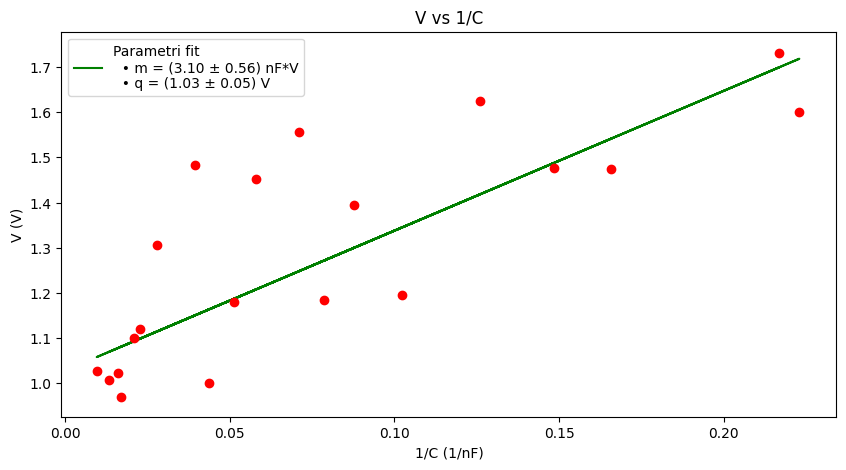

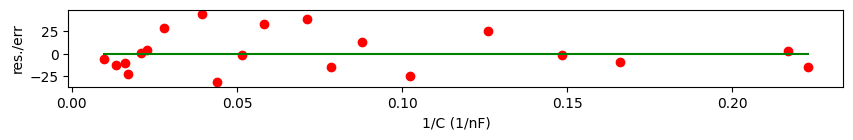

In [65]:
plt.figure(figsize=(10, 5))
plt.errorbar(c_rev, v, yerr = err_v, xerr = err_c_rev,fmt = "o", color = "red")
label_fit = (
    "Parametri fit"
    "\n  • " + f"m = ({par[0]:.2f} ± {dev_std[0]:.2f}) nF*V"
    "\n  • " + f"q = ({par[1]:.2f} ± {dev_std[1]:.2f}) V"
)
plt.plot(
    c_rev,
    linear_func(par, c_rev),
    color="green",
    label=label_fit)
plt.title("V vs 1/C")
plt.xlabel("1/C (1/nF)")
plt.legend()
plt.ylabel("V (V)")


# plot dei residui

plt.figure(figsize=(10,1),dpi=100)
plt.errorbar(c_rev, (v - linear_func(par, c_rev)) / err_v, 1, fmt="o", color = "red", zorder=1)

plt.plot([c_rev.min(), c_rev.max()], [0,0], zorder = 2, color = "green")

plt.xlabel("1/C (1/nF)")
plt.ylabel('res./err')
plt.show()

## Algoritmo per la convergeza di K_B

Nota bene: in questo processo vanno DIVISI  per $Z$ i valori ORIGINARIAMENTE misurati di $V_2$

In [66]:
print(list(c))
# print(c)

[9.77, 12.72, 4.486, 22.8, 35.71, 6.743, 6.029, 74.88, 62.4, 4.612, 14.05, 11.39, 43.88, 25.31, 7.935, 103.7, 17.23, 19.43, 58.8, 47.6]


In [67]:
eff = 5
count = 0
iter_max = 100
eps = np.array([10.7, 9.1, 18, 6.2, 5.5, 18, 18, 6.8, 6.3, 18, 8.2, 9.7, 5.5, 5.9, 18, 8.5, 7, 6.6, 6, 5.7])
Z = 1 - eps/100
q_atteso = 0 
threshold = 0.0001
v_new = []
q_values = []   
m_values = []  
err_q_values = []
err_m_values = []

v0 = v.copy()  # salvo i valori originariamente misurati

while eff >threshold and count < iter_max:
    
    # fit lineare su c_rev e v correnti
    errs_q_square = 0
    par, dev_std, cov = fit_lineare(c_rev, v, errx  = err_c_rev, erry = err_v + np.sqrt(errs_q_square))
    m, q = par
    err_m, err_q = dev_std
    errs_q_square += err_q**2
    
    q_values.append(q)
    m_values.append(m)
    err_q_values.append(err_q)
    err_m_values.append(err_m)
    
    # calcolo nuova v correggendo i valori originali
    q_sum = np.sum(q_values)
    v_new = (v0 - q_sum) / Z
    
    # aggiorno per iterazione successiva
    v = v_new.copy()
    
    eff = abs(q - q_atteso)
    count += 1

print(f"Convergenza raggiunta dopo {count} iterazioni: q → {q:.7f} +- {err_q_values[-1]}")

# stampa dei valori di q durante le iterazioni
print("\nValori di q durante le iterazioni:")
for i, val in enumerate(q_values, start=0):
    print(f"Iterazione {i}: q = {val:.9f} +-{err_q_values[i]}")

Convergenza raggiunta dopo 4 iterazioni: q → -0.0000260 +- 0.04986609866731354

Valori di q durante le iterazioni:
Iterazione 0: q = 1.027563060 +-0.04603959318550127
Iterazione 1: q = -0.014545284 +-0.04987710692042745
Iterazione 2: q = 0.000663724 +-0.04987875613319752
Iterazione 3: q = -0.000026008 +-0.04986609866731354


Perl'ultima iterazione, viene un errore relativo molto alto. In realtà me lo aspetto, dato che comunque i dati  si disperdono abbastanza.

In ogni caso, non è un fattore troppo importante, dato che alla fine $k_B$ non dipende dall'intercetta

Text(0, 0.5, 'V (V)')

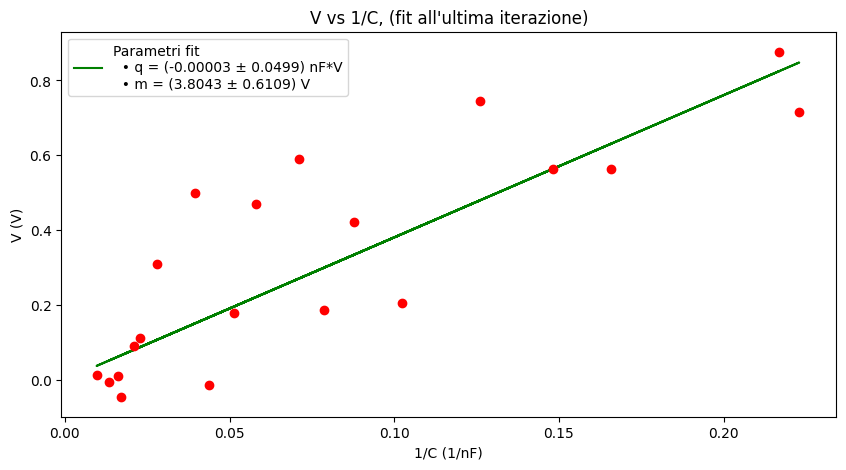

In [68]:
plt.figure(figsize=(10, 5))
plt.errorbar(c_rev, v_new, yerr = err_v, xerr = err_c_rev,fmt = "o", color = "red")
label_fit = (
    "Parametri fit"
    "\n  • " + f"q = ({q_values[-1]:.5f} ± {err_q_values[-1]:.4f}) nF*V"
    "\n  • " + f"m = ({m_values[-1]:.4f} ± {err_m_values[-1]:.4f}) V"
)
plt.plot(
    c_rev,
    linear_func(par, c_rev),
    color="green",
    label=label_fit)
plt.title("V vs 1/C, (fit all'ultima iterazione)")
plt.xlabel("1/C (1/nF)")
plt.legend()
plt.ylabel("V (V)")

In [69]:
print(q_values)
print(m_values)
print(err_m_values)

[1.027563060428901, -0.014545283988658194, 0.0006637235017954969, -2.600774730971391e-05]
[3.100101749632473, 3.7920883722961722, 3.8049267437504146, 3.8043032672716137]
[0.5610915291224674, 0.6108980840492558, 0.6109893714327947, 0.6108580973674411]


In [75]:
# print(f"kB  = {m.values[0]/T*U_star*10**-9}")
print(f"valore del coefficiente angolare e della costante di Boltzmann:\nm = {m_values[-1]}")
print(f"kB  = {m_values[-1]/T*U_star*10**-9} +- {err_m_values[-1]/T*U_star*10**-9}")



valore del coefficiente angolare e della costante di Boltzmann:
m = 3.8043032672716137
kB  = 1.4295816610666786e-23 +- 2.2954834884572015e-24


### Errore su $V_{new}$ 

Dato che la nuova $V_{new} =  /V - (\sum_{i = 1}^N q_i ) )/Z$ è calcolata tramite degli $q_i$ , che a loro volta hanno un errore (essendo parametri ricavati tramite un fit), allora l'errore su $V_{new}$ sarà diverso dall'errore su V (che aveva solo l'errore della lettura dello strumento)